In [1]:
# Imports
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [4]:
# Load dataset
df = pd.read_csv('lsdata1.csv', low_memory=False)
df2 = pd.read_csv('lsdata2.csv', low_memory=False)
df = pd.concat([df, df2])
print(df.shape)
df.head()

(955791, 28)


,user_id,simple_status,scholarship,sent_at,received_at,complete_at,ur_at,ur2_at,interview_at,decision_at,...,non_trad,gpa,is_international,international_gpa,years_out,is_lsn_import,is_military,is_character_and_fitness_issues,cycle_id,school_name
0,1911376,Rejected,NaN,2025-02-06,2025-02-07,2025-02-10,NaN,NaN,NaN,2025-04-08,...,False,3.84,False,NaN,3.0,False,False,False,23,University of Kansas
1,1886421,Pending,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,False,2.85,False,NaN,1.0,False,False,False,23,University of Illinois—Urbana Champaign
2,1912181,Pending,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,False,3.96,False,NaN,4.0,False,NaN,NaN,24,Vanderbilt University
3,1883281,Rejected,NaN,2024-11-18,2024-11-18,2024-12-05,2025-01-16,NaN,NaN,2025-02-07,...,False,3.11,False,NaN,3.0,False,False,False,23,University of Pennsylvania
4,1911709,Accepted,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2025-02-18,...,True,NaN,False,NaN,NaN,False,False,False,23,University of San Francisco


In [127]:
# Only consider year and month for sent date
df['year'] = df['sent_at'].map((lambda x : x.split('-')[0]), na_action='ignore')
df['month'] = df['sent_at'].map((lambda x : x.split('-')[1]), na_action='ignore')
df['day'] = df['sent_at'].map((lambda x : x.split('-')[2]), na_action='ignore')
df['dayofweek'] = pd.to_datetime(df['sent_at']).dt.dayofweek

In [128]:
# Drop rows where result is unknown
print(f"Shape before: {df.shape}")
df = df.dropna(subset='result')
print(f"Shape after: {df.shape}")

Shape before: (955791, 32)
Shape after: (954859, 32)


In [129]:
# Only keep results for top 30 most frequently applied schools -- may not have enough data for others
print(f"Shape before: {df.shape}")
top_schools = df['school_name'].value_counts().iloc[:30].index.tolist()
print(top_schools)
df = df[df['school_name'].isin(top_schools)]
print(f"Shape after: {df.shape}")

Shape before: (954859, 32)
['University of Virginia', 'Georgetown University', 'Duke University', 'University of Chicago', 'Columbia University', 'New York University', 'University of Pennsylvania', 'University of Michigan', 'Harvard University', 'University of California—Berkeley', 'Northwestern University', 'Vanderbilt University', 'George Washington University', 'University of California—Los Angeles', 'Washington University in St. Louis', 'Stanford University', 'Boston University', 'Cornell University', 'University of Texas at Austin', 'Yale University', 'University of Southern California', 'Boston College', 'Fordham University', 'American University', 'Emory University', 'University of Notre Dame', 'University of Georgia', 'William & Mary Law School', 'Arizona State University', 'Washington and Lee University']
Shape after: (568678, 32)


In [130]:
# Coerce result values into Accepted, Rejected, Waitlisted -- everything else can be dropped
print(f"Shape before: {df.shape}")
mask = df['result'].str.contains('accept', case=False, na=False)
df.loc[mask, 'result'] = 'Accepted'
mask = df['result'].str.contains('reject', case=False, na=False)
df.loc[mask, 'result'] = 'Rejected'
mask = df['result'].str.contains('waitlist', case=False, na=False)
df.loc[mask, 'result'] = 'Waitlist'
df = df[df['result'].isin(['Accepted', 'Rejected', 'Waitlist'])]
df = df.dropna(subset='result')
print(f"Shape after: {df.shape}")

Shape before: (568678, 32)
Shape after: (333779, 32)


In [131]:
# Get dependent and independent variables
X_col = ['year', 'month', 'day', 'dayofweek', 'is_in_state', 'is_fee_waived', 'lsat', 'softs', 'urm', 'non_trad', 'gpa', 'is_international', 'international_gpa', 'years_out', 'is_military', 'is_character_and_fitness_issues', 'school_name']
Y_col = ['result']
X = df[X_col]
Y = df[Y_col]

In [132]:
# Split into train and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [134]:
# Get numerical and categorical features for preprocessing
numerical_features = X_train.select_dtypes(include=np.number).columns.tolist()
boolean_features = X_train.select_dtypes(include='boolean').columns.tolist()
categorical_features = X_train.select_dtypes(include=['object', 'category']).columns.tolist()
for val in ['is_military', 'is_character_and_fitness_issues']:
  categorical_features.remove(val)
  boolean_features.append(val)
print("Numerical Features:", numerical_features)
print("Boolean Features:", boolean_features)
print("Categorical Features:", categorical_features)

Numerical Features: ['dayofweek', 'lsat', 'gpa', 'years_out']
Boolean Features: ['is_in_state', 'is_fee_waived', 'urm', 'non_trad', 'is_international', 'is_military', 'is_character_and_fitness_issues']
Categorical Features: ['year', 'month', 'day', 'softs', 'international_gpa', 'school_name']


In [135]:
# Build individual transformers and combine
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean'))
])
boolean_transformer = Pipeline(steps=[
    ('caster', FunctionTransformer(lambda x: x.astype(object))),
    ('imputer', SimpleImputer(strategy='most_frequent'))
])
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='Missing')),
    ('string_caster', FunctionTransformer(lambda x: x.astype(str))),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=True))
])
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('bool', boolean_transformer, boolean_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough',
    sparse_threshold=0.0
)

In [136]:
# Build pipeline with model
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', HistGradientBoostingClassifier(random_state=42))
])

In [137]:
# Train model
model.fit(X_train, Y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   sparse_threshold=0.0,
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer())]),
                                                  ['dayofweek', 'lsat', 'gpa',
                                                   'years_out']),
                                                 ('bool',
                                                  Pipeline(steps=[('caster',
                                                                   FunctionTransformer(func=<function <lambda> at 0x7f747c7b85e0>)),
                                                                  ('imputer',
                                                                   SimpleImputer(strategy='most_frequent'))]...
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='Missing',
                                                                                 strategy='constant')),
                                                                  ('string_caster',
                                                                   FunctionTransformer(func=<function <lambda> at 0x7f747c7b8e00>)),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['year', 'month', 'day',
                                                   'softs', 'international_gpa',
                                                   'school_name'])])),
                ('classifier',
                 HistGradientBoostingClassifier(random_state=42))])

In [138]:
# Predict on the test set
output = model.predict(X_test)

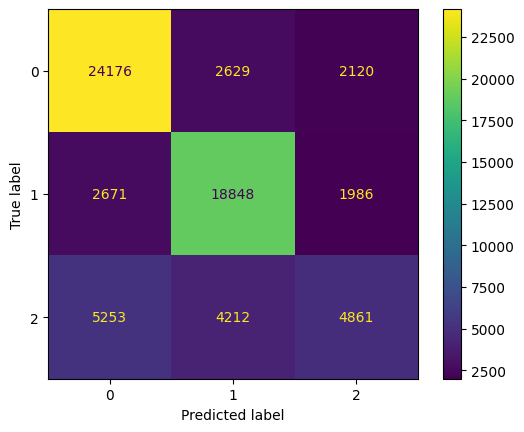

In [139]:
# Show confusion matrix
ConfusionMatrixDisplay(confusion_matrix(Y_test, output)).plot()
plt.show()

In [140]:
# Show validation statistics
print(classification_report(Y_test, output))

              precision    recall  f1-score   support

    Accepted       0.75      0.84      0.79     28925
    Rejected       0.73      0.80      0.77     23505
    Waitlist       0.54      0.34      0.42     14326

    accuracy                           0.72     66756
   macro avg       0.68      0.66      0.66     66756
weighted avg       0.70      0.72      0.70     66756



In [196]:
# Get individual result

# Year applied
year = 2024
# Month applied
month = 9
# Day applied
day = 25
# Day of week applied -- don't touch
dayofweek = pd.to_datetime(f"{year}-{month}-{day}").dayofweek
# Are you in state? True if yes, False if no
is_in_state = False
# Did you have your application fee waived? True if yes, False if no
is_fee_waived = False
# LSAT score
lsat = 172
# Softs -- one of the following (based on lsd.law rubric): T1, T2, T3, T4
softs = 'T3'
# Are you an underrepresented minority (URM)?
urm = True
# Are you a nontraditional applicant?
non_trad = False
# LSAC GPA
gpa = 3.83
# Are you an international student? True if yes, False if no
international = False
# If you are international, what was your GPA? Select one of the following: Superior, Above Average, Average, Below Average
# Use np.nan if not international
international_gpa = np.nan
# How many years out of college are you? 0 if KJD, etc.
years_out = 8
# Are you currently, or have you been part of the military? True if yes, False if no
is_military = False
# Do you have any character and fitness issues? True if yes, False if no
is_character_and_fitness_issues = False
# What school are you looking to apply to? Only write one
school_name = 'University of California-Los Angeles'

indiv_df = pd.DataFrame({
    'year': [year],
    'month': [month],
    'day': [day],
    'dayofweek': [dayofweek],
    'is_in_state': [is_in_state],
    'is_fee_waived': [is_fee_waived],
    'lsat': [lsat],
    'softs': [softs],
    'urm': [urm],
    'non_trad': [non_trad],
    'gpa': [gpa],
    'is_international': [international],
    'international_gpa': [international_gpa],
    'years_out': [years_out],
    'is_military': [is_military],
    'is_character_and_fitness_issues': [is_character_and_fitness_issues],
    'school_name': [school_name]
})
output = model.predict_proba(indiv_df)[0]
output_dict = {
    'Accepted': output[0],
    'Rejected': output[1],
    'Waitlist': output[2]
}
output = max(output_dict, key=output_dict.get)
RESET = "\033[0m"
BOLD = "\033[1m"
RED = "\033[31m"
GREEN = "\033[32m"
YELLOW = "\033[33m"
colors = {
    'Accepted': GREEN,
    'Rejected': RED,
    'Waitlist': YELLOW
}
print(f"According to your profile, you are most likely to be {colors[output]}{BOLD}{output + 'ed' if output == 'waitlist' else output}{RESET} at {school_name}.")
print(f"Accepted: {round(output_dict['Accepted'] * 100, 2)}%")
print(f"Rejected: {round(output_dict['Rejected'] * 100, 2)}%")
print(f"Waitlisted: {round(output_dict['Waitlist'] * 100, 2)}%")

According to your profile, you are most likely to be Accepted at University of California-Los Angeles.
Accepted: 48.71%
Rejected: 13.58%
Waitlisted: 37.71%
